# Urban Sound Classificaiton
****

## 1.1 Importing Libraries

In [194]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from scipy.io import wavfile as wav
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

In [181]:
meta_data = pd.read_csv("metadata/UrbanSound8K.csv")  

np.shape(meta_data) # (8732, 8)
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [182]:
print((meta_data.classID.value_counts().sort_index()))

0    1000
1     429
2    1000
3    1000
4    1000
5    1000
6     374
7    1000
8     929
9    1000
Name: classID, dtype: int64


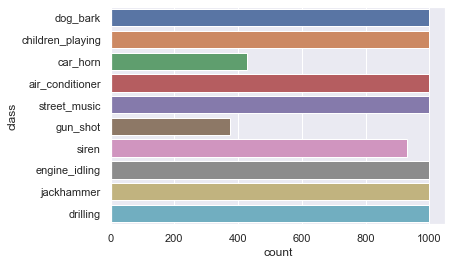

In [183]:
sns.set(style="darkgrid")
sns.countplot(y= meta_data['class'],orient='v')
plt.show()

4.0

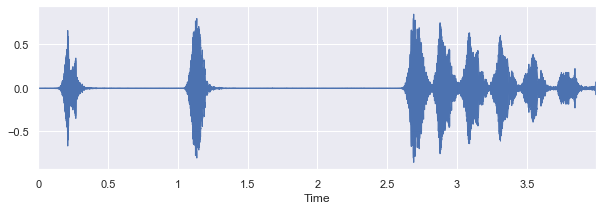

In [170]:
# Class: Car horn 
filename = 'audio/fold1/101415-3-0-2.wav'
plt.figure(figsize=(10,3))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)


### 1.2  Extracting the metadata of the audio

In [184]:
audio_d_list = []

for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    
    # extracting channels, sampling rate, bit rate and duration
    data = sf.SoundFile(file_name)
    duration = float(meta_data.iloc[index,3])-float(meta_data.iloc[index,2])
    audio_d_list.append([data.channels,
                         data.samplerate,
                         data.subtype[4:],
                         duration])

audio_data = pd.DataFrame(audio_d_list, 
                          columns=['num_channels','sample_rate','bit_depth','duration'])

In [185]:
audio_data.head()

,num_channels,sample_rate,bit_depth,duration
0,2,44100,16,0.317551
1,2,44100,16,4.000000
2,2,44100,16,4.000000
3,2,44100,16,4.000000
4,2,44100,16,4.000000


***
***

## 2. Inital Data Analysis

### 2.1   Duration of Audio

In [186]:
print(audio_data.duration)

0       0.317551
1       4.000000
2       4.000000
3       4.000000
4       4.000000
          ...   
8727    4.000000
8728    2.142545
8729    3.505983
8730    2.532098
8731    2.532099
Name: duration, Length: 8732, dtype: float64


### 2.2 Number of Channels

Sound Channel refers to the independent audio signal which is collected or playback when the sound is recording or playback in different spatial position. Therefore, the number of channel is the amount of sound source when the sound is recording or the relevant speaker number when it is playback

In [187]:
print(audio_data.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


### 2.3 Bit Depth

Bit depth describes the resolution of the sound data that is captured and stored in an audio file. A higher audio bit depth indicates a more detailed sound recording.

In [188]:
print(audio_data.bit_depth.value_counts(normalize=True))

16       0.659414
24       0.315277
T        0.019354
U8       0.004924
DPCM     0.000916
ADPCM    0.000115
Name: bit_depth, dtype: float64


### 2.4 Sampling Frequency or Sample Rate

In audio production, a sample rate (or "sampling frequency") defines how many times per second a sound is sampled. Technically speaking, it is the frequency of samples used in a digital recording. 

In [189]:
print(audio_data.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


****
****

## 3. Data Pre-Processing

Using Librosa’s load() function:  
* Converts the sampling rate to 22.05 KHz
* Normalise the Bit-depth values of the audio
* Merge the audio channels to Mono (a single channel) 

Using Librosa MFCC function: 
* Extracting Mel Frequency Cepstral Coefficient 

In [190]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [191]:
def feature_extractor(file_name,scale=False,padding=False,max_pad=None,n=40):
    '''
    Function to extract features from the audio file
    Does the following things using Librosa library:
        - Converts the sampling rate to 22.05 KHz
        - Normalize the Bit-depth values of the audio
        - Merge the audio channels into a Mono (single) channel
    Parameters: 
    Input:
        file_name : string; 
                    Path of the file to be processed 
        scale : False; 
                True when 1D features are required calculated 
                by taking mean along the axis
        padding : False; 
                  True when 2D features are required with padding
        max_pad : None [int]; 
                  Maxium size of a padded image/array. 
                  Required when padding is set to True
        n = 40 [int]; 
            Number of MFCCs to return          
    Output:
        mfccs = array of mfccs features.
                (1D when scaling = True
                 2D when padding = True)   
    '''
    try:        
        audio, sample_rate = librosa.load(file_name, 
                                          res_type='kaiser_fast') 
        
        mfccs = librosa.feature.mfcc(y = audio, 
                                     sr = sample_rate, 
                                     n_mfcc = n) 
            
        if padding:
            pad_width = max_pad - mfccs.shape[1]
            mfccs = np.pad(mfccs, 
                           pad_width=((0, 0), (0, pad_width)), 
                           mode='constant')
            
        if scale: 
            mfccs = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

### 1-Dimensional Feature Extraction

In [203]:
feat_list = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    
    data = feature_extractor(file_name,scale=True)
    feat_list.append([data, class_label])

features_1D = pd.DataFrame(feat_list, columns=['feature','class_label'])

print('Processed ', len(features_1D), ' files')
print('Output Feature shape ',np.shape(features_1D.iloc[0,0]))

Processed  8732  files
Output Feature shape  (40,)


### 2-Dimensional Feature Extraction with Padding

In [202]:
feat_list = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    
    data = feature_extractor(file_name,padding=True,max_pad = 174)
    feat_list.append([data, class_label])

features_2D = pd.DataFrame(feat_list, columns=['feature','class_label'])

print('Processed ', len(features_2D), ' files')
print('Output Feature shape ',np.shape(features_2D.iloc[0,0]))

Processed  8732  files
Output Feature shape  (40, 174)


### Label Encoding

In [204]:
# Convert features and corresponding classification labels into numpy arrays
X_1D = np.array(features_1D.feature.tolist())
y_1D = np.array(features_1D.class_label.tolist())

# Encode the classification labels
label_encoder = LabelEncoder()
yy_1D = to_categorical(label_encoder.fit_transform(y_1D))

In [205]:
# Convert features and corresponding classification labels into numpy arrays
X_2D = np.array(features_2D.feature.tolist())
y_2D = np.array(features_2D.class_label.tolist())

# Encode the classification labels
yy_2D = to_categorical(label_encoder.transform(y_2D)) 

### Splitting the Dataset

In [206]:
x_train_1D, x_test_1D, y_train_1D, y_test_1D = train_test_split(X_1D, yy_1D, test_size=0.2, random_state = 42)
x_train_2D, x_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, yy_2D, test_size=0.2, random_state = 42)

****
****

# Classification using Different Algorithms

Following will be used for classification:    
    
1. Random Forest
2. Support Vector Machine 
2. Mulit-layer Perceptron (ANN)
3. Convolutional Neural Network (CNN)

## 1. Random Forest Classification

## 2. Support Vector Machine   

## 3. Multi-Layer perceptron

In [207]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

### Model Definition

In [208]:
num_labels = yy_1D.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Model Summary

In [210]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_train_1D, y_train_1D, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

### Model Execution

In [211]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train_1D, 
          y_train_1D, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test_1D, y_test_1D), 
          callbacks=[checkpointer], 
          verbose=1)

duration = datetime.now() - start
print("Training finished in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 87us/step - loss: 7.8396 - accuracy: 0.1990 - val_loss: 2.1262 - val_accuracy: 0.2559

Epoch 00001: val_loss improved from inf to 2.12625, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
6985/6985 [==============================] - 0s 58us/step - loss: 2.2318 - accuracy: 0.2527 - val_loss: 1.9289 - val_accuracy: 0.3641

Epoch 00002: val_loss improved from 2.12625 to 1.92894, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
6985/6985 [==============================] - 0s 59us/step - loss: 1.9758 - accuracy: 0.3094 - val_loss: 1.7855 - val_accuracy: 0.4259

Epoch 00003: val_loss improved from 1.92894 to 1.78551, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 4/100
6985/6985 [==============================] - 0s 58us/step - loss: 1.8593 - accuracy: 0.3530 - val_loss: 1.6091 - val_accuracy: 0.4310

Epoch 00004: val_loss improve

### Model Evalutaion

In [212]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train_1D, y_train_1D, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test_1D, y_test_1D, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9275590777397156
Testing Accuracy:  0.8752146363258362


****
****

## 4. Convolutional Neural Network

In [213]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

### Data reshaping 

In [214]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train_2D = x_train_2D.reshape(x_train_2D.shape[0], num_rows, num_columns, num_channels)
x_test_2D = x_test_2D.reshape(x_test_2D.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_2D.shape[1]
filter_size = 2

### Model Definition

In [215]:
# Model Configuration

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Summarizing Model

In [216]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test_2D, y_test_2D, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 41, 64)        

### Model Execution

In [217]:
num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train_2D, 
          y_train_2D, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test_2D, y_test_2D), 
          callbacks=[checkpointer], 
          verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/72
6985/6985 [==============================] - 13s 2ms/step - loss: 4.9276 - accuracy: 0.1865 - val_loss: 1.9220 - val_accuracy: 0.3137

Epoch 00001: val_loss improved from inf to 1.92196, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 2/72
6985/6985 [==============================] - 11s 2ms/step - loss: 1.9563 - accuracy: 0.3250 - val_loss: 1.8344 - val_accuracy: 0.3950

Epoch 00002: val_loss improved from 1.92196 to 1.83437, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 3/72
6985/6985 [==============================] - 11s 2ms/step - loss: 1.7272 - accuracy: 0.3838 - val_loss: 1.6841 - val_accuracy: 0.4516

Epoch 00003: val_loss improved from 1.83437 to 1.68408, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 4/72
6985/6985 [==============================] - 11s 2ms/step - loss: 1.5393 - accuracy: 0.4553 - val_loss: 1.5313 - val_accuracy: 0.4797

Epoch 00004: val_loss improved fr

In [218]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train_2D, y_train_2D, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9341446161270142
Testing Accuracy:  0.8849456310272217


In [111]:
def predict(file_name):
    pred_feature = extract_features(file_name) 
    pred_feature = pred_feature.reshape(1, num_rows, num_columns, num_channels)

    pred_v = model.predict_classes(pred_feature)
    pred_clacces = label_encoder_2D.inverse_transform(pred_v) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )